# U-Net for Medical Image Segmentation

**Welcome to the CNN tutorial for Chest X-Ray Image Segmentation!**

This tutorial is based on the article written by Abhinav Saga for *Towards Data Science*. The original article can be found <a href="https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8">here</a>.

This tutorial requires data hosted on Kaggle.com (<a href="https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia">source</a>). 

**You will need to create a verified Kaggle account, download the data and change the source directory in this file.**

Let's get started!

## Importing Packages and Dependencies
To get started, we need to import the required packages which the code will use. The architecture of the neural network will use Keras. 

Keras is a high level machine learning API which uses TensorFlow as a backend. This allows users to focus on implementation from a more blackbox perspective. TensorFlow is much better suited for more whitebox approaches. TensorFlow uses a structure called tensors which a basically n-dimensional arrays or matricies. We can use NumPy arrays to pass to TensorFlow and Keras.

In [9]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
import keras.backend as k
import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

## Importing Images
We now need to set an input path from which to load images. **You must change the following line to point to the correct folder on your system.**

In [30]:
inPath = "C:/Datasets/ChestXRay/chest_xray/chest_xray"

## Testing the Filepath
You can verify that the path has been set correctly by counting the images from the dataset.

The for loop below simply counts and displays the number of images in each directory. This gives us an idea of how many images we are dealing with in each set. You should confirm that your output is as follows:<br />
`Set: /train` <br />
`Normal Images: 1342 ` <br />
`Pneumonia Images: 3876` <br />
<br />
`Set: /val` <br />
`Normal Images: 9` <br />
`Pneumonia Images: 9` <br />
<br />
`Set: /test` <br />
`Normal Images: 234` <br />
`Pneumonia Images: 390` <br />

In [33]:
for subset in ['/train', '/val', '/test']:
    normal = len(os.listdir(inPath + subset + "/NORMAL"))
    pneumonia = len(os.listdir(inPath + subset + "/PNEUMONIA"))
    print("Set: " + str(subset) + "\nNormal Images: " + str(normal) + "\nPneumonia Images: " + str(pneumonia) + "\n~~~~~~~~")

Set: /train
Normal Images: 1342
Pneumonia Images: 3876
~~~~~~~~
Set: /val
Normal Images: 9
Pneumonia Images: 9
~~~~~~~~
Set: /test
Normal Images: 234
Pneumonia Images: 390
~~~~~~~~


## Preparing the Data
Now that we have confirmed that we have access to the images, we need to process it into sets to that it be passed to the CNN. Abhinav does this by splitting the the images into training, validation and test sets. They also implement a technique called data augmentation. Because deep learning algorithms perform better with more training data, data augmentation is used to increase the size of the dataset used to train the model. This is relatively easy and a dataset size can be quadrupled simply by rotating images 90, 180 and 270 degrees though other methods also exist like flipping pictures. <br />
During this next step, a function is defined which augments and processes image data to prepare it to be passed to the model. The data is augmented using a Keras class called ImageDataGenerator which augments imagesets in real-time with the flow_from_directory() method.<br />
The function also resizes images and prepares them for the model.
<br />
<br /> Abhinav uses the following code:

In [43]:
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    input_path = inPath
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'/train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'/test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + '/test' + cond)):
            img = plt.imread(input_path+'/test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

## Hyperparameters
Hyperparameters are parameters that the creator of the algorithm must choose and directly affect model training accuracy. <br />
The `img_dims` variable represents the size of the image in pixels that the images will be resized to. Having a larger image size will drastically increase training 
time is set too high. Too small dimensions, however, results in poor training because information which which to learn is lost from the image when resized. <br />
The `epochs` variable represents the number of times the model runs through the complete training set. Too many epochs result in long wait times and may actually reduce the accuracy of the
learned model. Too little epochs and the model will not learn enough. <br/>
Finally, the `batch_size` variable is that controls the number of training samples to work through before a models internal parameters (like weights) are updated. Having too large a batch size will use a lot more resources and increase training time.<br />
<br />
The `train_gen`, `test_gen`, `test_data` and `test_labels` variables represent the training and test datasets which will be used to train the model. 
These variables are set below. We will experiment with different hyperparameters toward the end of this tutorial. For now the defaults remain: <br/>
`img_dims = 150
epochs = 10
batch_size = 32`

In [44]:
img_dims = 150
epochs = 10
batch_size = 32

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Defining the CNN Architecture
The most important (and fun) step! Keras makes creating neural networks extremely intuitive and easy. In fact, it may seem like all the previous steps are the most difficult to understand initially. <br />
To generate this CNN, we must first contruct each layer in the neural network. We'll walk through Abhinav's CNN layer by layer.<br/>
But, before we get started, we need to create an input tensor (a matrix) that is the dimensions of the images being used to train the neural network and an added third dimension of 3. This third dimension is due to the three channels used to compose JPEG images (height x width x channel) which are actually three dimensional array data structures!

In [45]:
inputs = Input(shape=(img_dims, img_dims, 3))

Now we create the first layers in the CNN, which takes `inputs`, the JPEG images, as an input. The convolutional layer scans a kernel across the image and produces another tensor which maps the activation of the kernel across the image. This is the first step in feature extraction. The resulting tensor created from this convolutional layer is then passed to another convolutional layer, and the tensor output by this layer is passed to a maxpooling layer that reduces dimensionality of the data and helps the network to learn and extract features from the image produced the convolution. This completes the first convolutional block.

In [49]:
# first conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

In [50]:
# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

Finally, an FC layer is present which classifies the features extracted by the previous convolutional layers and passes this information to the output layer.


In [51]:
# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

Now, we create and compile the model.

In [52]:
# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

## Model Training
Finally, we can train the model! 
<br/>
The model.fit_generator() method trains the model and creates a history to help visualize and track the training process.

In [53]:
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/10
163/163 [==============================] - 285s 2s/step - loss: 0.3629 - accuracy: 0.8269 - val_loss: 1.5814 - val_accuracy: 0.6234
Epoch 2/10
163/163 [==============================] - 308s 2s/step - loss: 0.2606 - accuracy: 0.8832 - val_loss: 2.7007 - val_accuracy: 0.6334
Epoch 3/10
163/163 [==============================] - 299s 2s/step - loss: 0.2525 - accuracy: 0.8953 - val_loss: 0.5621 - val_accuracy: 0.6115
Epoch 4/10
163/163 [==============================] - 347s 2s/step - loss: 0.2317 - accuracy: 0.9122 - val_loss: 6.8338 - val_accuracy: 0.6334
Epoch 5/10
163/163 [==============================] - 382s 2s/step - loss: 0.2132 - accuracy: 0.9222 - val_loss: 0.3811 - val_accuracy: 0.7145
Epoch 6/10
163/163 [==============================] - 365s 2s/step - loss: 0.1989 - accuracy: 0.9201 - val_loss: 0.4473 - val_accuracy: 0.6824

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/10
163/163 [==============================] - 301s 2s

Using the history, we can create loss and accuracy plots to visualize model training.

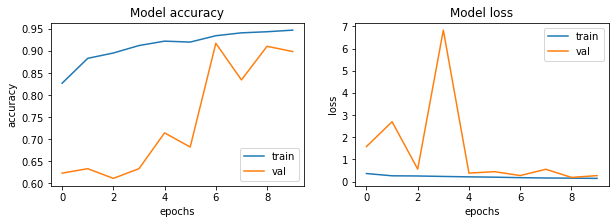

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

We can also gather more useful data like accuracy and pricision by calculating a confusion matrix and other test metrics. Abhinav uses the following code.

In [57]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[198  36]
 [ 29 361]]

TEST METRICS ----------------------
Accuracy: 89.58333333333334%
Precision: 90.93198992443325%
Recall: 92.56410256410257%
F1-score: 91.74078780177891

TRAIN METRIC ----------------------
Train acc: 94.71


## Experiment with Hyperparameters
Now you can edit the hyperparametes above and re-run the proceeding steps again to observe any changes. <br/>What changes increase training time?<br/> What changes increase accuracy?<br/> Can you outperform your initial result by altering these parameters?